In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))
os.chdir("../")

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import torch

# Overlay Mesh Graph on UK Map

In [3]:
proj = ccrs.PlateCarree()

In [4]:
def add_geo_features(ax):
    ax.add_feature(cfeature.BORDERS, linestyle=':')
      
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
def add_cities(ax, cities):
    for city, (lon, lat) in cities.items():
        ax.plot(lon, lat, 'ro', transform=proj)
        ax.text(lon + 0.1, lat + 0.1, city, transform=proj)
        
def bounding_box(ax, box):
    lon_min, lon_max, lat_min, lat_max = box
    top_left = [lon_min, lat_max]
    top_right = [lon_max, lat_max]
    bottom_left = [lon_min, lat_min]
    bottom_right = [lon_max, lat_min]
    
    corners = [
        bottom_left,
        top_left,
        top_right,
        bottom_right,
        bottom_left,
    ]
    
    lons, lats = zip(*corners)
    
    ax.plot(
        lons, lats,
        "r-", 
        transform=proj
    )
    

def grid_points(ax, grid_xy):
    ax.plot(grid_xy[0], grid_xy[1], 'ro', transform=proj, markersize=1)

def mesh_points(ax, mesh_pos):
    ax.plot(mesh_pos[0], mesh_pos[1], 'go', transform=proj, markersize=3)

def m2m_edges(ax, mesh_pos, m2m_edge_set):        
    for edge in m2m_edge_set:
        source = mesh_pos[:, edge[0]]
        target = mesh_pos[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "g-", 
            transform=proj,
            linewidth=0.5
        )
        
def g2m_edges(ax, grid_xy, mesh_pos, g2m_edge_set): 
    for edge in g2m_edge_set:
        source = grid_xy[:, edge[0]]
        target = mesh_pos[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "b-", 
            transform=proj,
            linewidth=0.5
        )

def m2g_edges(ax, grid_xy, mesh_pos, m2g_edge_set):        
    for edge in m2g_edge_set:
        source = mesh_pos[:, edge[0]]
        target = grid_xy[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "r-", 
            transform=proj,
            linewidth=0.5
        )
        
def degrees(edge_index):
    degrees = [0] * (max(edge_index[0]) + 1)
    for i in range(edge_index.shape[1]):
        degrees[edge_index[0, i]] += 1
        
    return max(degrees), min(degrees)

## Original Modulus Meshgrid

In [5]:
input_res = (721, 1440) # (lat, lon)

latitudes = torch.linspace(-90, 90, steps=input_res[0])
longitudes = torch.linspace(-180, 180, steps=input_res[1] + 1)[1:]
lat_lon_grid = torch.stack(
    torch.meshgrid(latitudes, longitudes, indexing="ij"), dim=-1
) # (2, lon, lat)
# a, b = lat_lon_grid
# print([a.min(), a.max(), b.min(), b.max()])

print(lat_lon_grid.shape)
lat_lon_grid_flat = lat_lon_grid.permute(2, 0, 1).view(2, -1).permute(1, 0)
print(lat_lon_grid_flat.shape)
a, b = lat_lon_grid_flat[:, 0], lat_lon_grid_flat[:, 1]
print([a.min(), a.max(), b.min(), b.max()])

torch.Size([721, 1440, 2])
torch.Size([1038240, 2])
[tensor(-90.), tensor(90.), tensor(-179.7500), tensor(180.)]


## New Modulus Meshgrid

In [6]:
input_res = (721, 1440) # (lat, lon)
latitudes = torch.linspace(-90, 90, steps=input_res[0])
longitudes = torch.linspace(-180, 180, steps=input_res[1] + 1)[1:]
lat_lon_grid = torch.stack(
    torch.meshgrid(longitudes, latitudes, indexing="ij"), dim=0
) # (2, lon, lat)
print(lat_lon_grid.shape)
# a, b = lat_lon_grid
# print([a.min(), a.max(), b.min(), b.max()])

lat_lon_grid_flat = lat_lon_grid.reshape(2, -1).T
print(lat_lon_grid_flat.shape)
a, b = lat_lon_grid_flat[:, 0], lat_lon_grid_flat[:, 1]
print([a.min(), a.max(), b.min(), b.max()])

torch.Size([2, 1440, 721])
torch.Size([1038240, 2])
[tensor(-179.7500), tensor(180.), tensor(-90.), tensor(90.)]


In [7]:
# Load grid nodes
dir = "./data/era5_uk/static/nwp_xy.npy"
# dir = "./data/era5_uk_big/static/nwp_xy.npy"
# dir = "./data/era5_global/static/nwp_xy.npy"
grid_xy = np.load(dir)
print(grid_xy.shape)
a, b = grid_xy
# a = a.flatten()
# b = b.flatten()
print([a.min(), a.max(), b.min(), b.max()])
grid_xy = grid_xy.reshape(2, -1)

(2, 57, 65)
[-10.0, 4.0, 47.0, 63.0]


In [8]:
# Load mesh nodes
graph_name = "uk_graphcast"
# graph_name = "uk_big_graphcast"
# graph_name = "global_graphcast"
graph_dir_path = os.path.join("graphs", graph_name)
mesh_pos = torch.load(os.path.join(graph_dir_path, "mesh_pos.pt")).T # (2, n_mesh)
print(mesh_pos.shape)
a, b = mesh_pos
[a.min(), a.max(), b.min(), b.max()]

torch.Size([2, 149])


[tensor(-11.0435), tensor(5.0456), tensor(46.6051), tensor(63.2954)]

## Load datas

In [43]:
# Load dataset and graph
# dir = "./data/era5_uk/static/nwp_xy.npy"
# graph_name = "uk_graphcast"

# dir = "./data/era5_global/static/nwp_xy.npy"
# graph_name = "global_graphcast"

# dir = "./data/era5_uk_big/static/nwp_xy.npy"
# graph_name = "uk_big_graphcast"

dir = "./data/era5_uk_big/static/nwp_xy.npy"
graph_name = "test_uk_big_graphcast"

# dir = "./data/era5_global/static/nwp_xy.npy"
# graph_name = "test_global_graphcast"

graph_dir_path = os.path.join("graphs", graph_name)

In [44]:
# Load grid
grid_xy = np.load(dir)
print(grid_xy.shape)
grid_xy = grid_xy.reshape(2, -1)

# Load mesh nodes
# mesh_pos = np.load(os.path.join(graph_dir_path, "mesh_pos.npy"))
mesh_pos = torch.load(os.path.join(graph_dir_path, "mesh_pos.pt")).T # (2, n_mesh)
mesh_pos = mesh_pos[[0, 1]]
m2m_edge_index = torch.load(os.path.join(graph_dir_path, "m2m_edge_index.pt"))[0]
edge_set = {tuple(sorted(e)) for e in m2m_edge_index.T}

g2m_edge_index = torch.load(os.path.join(graph_dir_path, "g2m_edge_index.pt"))
g2m_edge_set = sorted(list({tuple(e) for e in g2m_edge_index.T}))

m2g_edge_index = torch.load(os.path.join(graph_dir_path, "m2g_edge_index.pt"))
m2g_edge_set = sorted(list({tuple(e) for e in m2g_edge_index.T}))

(2, 81, 81)


In [45]:
a, b = mesh_pos
[a.min(), a.max(), b.min(), b.max()]

[tensor(-14.1328), tensor(8.1170), tensor(44.2927), tensor(65.3321)]

In [46]:
print("Verify g2m connectivity")
print("Grid Nodes min, max: ", g2m_edge_index[0].min(), g2m_edge_index[0].max())
print("Mesh nodes min, max: ", g2m_edge_index[1].min(), g2m_edge_index[1].max())
print("Grid Nodes unique:", g2m_edge_index[0].unique().shape[0])
print("Mesh nodes unique:", g2m_edge_index[1].unique().shape[0])

Verify g2m connectivity
Grid Nodes min, max:  tensor(0) tensor(6560)
Mesh nodes min, max:  tensor(0) tensor(258)
Grid Nodes unique: 6561
Mesh nodes unique: 259


In [47]:
print("Verify m2g connectivity")
print("Grid Nodes min, max: ", m2g_edge_index[0].min(), m2g_edge_index[0].max())
print("Mesh nodes min, max: ", m2g_edge_index[1].min(), m2g_edge_index[1].max())
print("Grid Nodes unique:", m2g_edge_index[0].unique().shape[0])
print("Mesh nodes unique:", m2g_edge_index[1].unique().shape[0])

Verify m2g connectivity
Grid Nodes min, max:  tensor(0) tensor(258)
Mesh nodes min, max:  tensor(0) tensor(6560)
Grid Nodes unique: 259
Mesh nodes unique: 6561


In [48]:
lon, lat = grid_xy
grid_extent = [lon.min(), lon.max(), lat.min(), lat.max()]
grid_extent

[-13.0, 7.0, 45.0, 65.0]

Map Bounding box:
[-13.0, 7.0, 45.0, 65.0]


Text(0.5, 1.0, 'ERA5 UK - GraphCast')

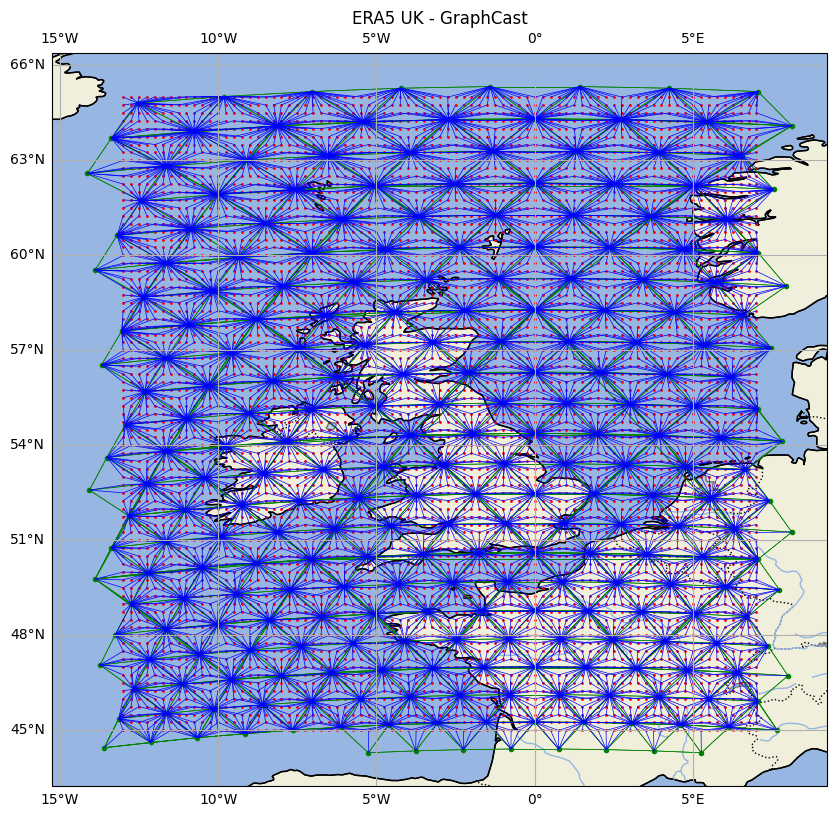

In [50]:
# Create a map with PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})

# Set the extent to focus on the UK
lon, lat = grid_xy
uk_extent = [lon.min(), lon.max(), lat.min(), lat.max()]
# print(uk_extent)
# uk_extent = [lon.min() - 2, lon.max() + 2, lat.min() - 2, lat.max() + 2]
# uk_extent = [lon.min() - 8, lon.max() + 8, lat.min() - 4, lat.max() + 4]
# ax.set_extent(uk_extent)
print("Map Bounding box:")
print(uk_extent)

# Add geographical features
add_geo_features(ax)

# Add cities
# cities = {
#     'London': (-0.1276, 51.5074),
#     'Edinburgh': (-3.1883, 55.9533),
#     'Cardiff': (-3.1791, 51.4816),
#     'Belfast': (-5.9301, 54.5973)
# }
# add_cities(ax, cities)

# Add grid nodes
grid_points(ax, grid_xy)

# Add mesh nodes
mesh_points(ax, mesh_pos)

# Add m2m edges
m2m_edges(ax, mesh_pos, edge_set)

# Add g2m edges
g2m_edges(ax, grid_xy, mesh_pos, g2m_edge_set)

# Add m2g edges
# m2g_edges(ax, grid_xy, mesh_pos, m2g_edge_set)

# small_uk = [-14.015517, 2.0919117, 49.674, 61.061]
# small_uk = [-13.0, 7.0, 45.0, 65.0]
# print("UK Bounding box:")
# print(small_uk)
# print(small_uk[1] - small_uk[0], small_uk[3] - small_uk[2])
# bounding_box(ax, small_uk)

# uk_settlments = [-8.00, 1.75, 49.75, 61.00]
# print("UK Settlements Bounding box:")
# print(uk_settlments)
# bounding_box(ax, uk_settlments)

# Add gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_lables = False
gl.right_labels = False

plt.title('ERA5 UK - GraphCast')

In [25]:
lon, lat = mesh_pos

In [26]:
uk_extent

[-10.0, 4.0, 47.0, 63.0]

In [27]:
(18 - 2) * 4 

64

In [28]:
[lon.min() - 4, lon.max() + 4, lat.min() - 8, lat.max() + 8]

[tensor(-15.0435), tensor(9.0456), tensor(38.6051), tensor(71.2954)]

In [13]:
print(lon.max() - lon.min())
print(lat.max() - lat.min())

14.0
16.0


In [14]:
[float(i) for i in ["49.6740000","61.0610000","-14.0155170","2.0919117"]]

[49.674, 61.061, -14.015517, 2.0919117]

In [15]:
num_lon = (lon.max() - lon.min()) * 4 + 1
num_lat = (lat.max() - lat.min()) * 4 + 1

In [16]:
print("Grid Nodes: ", grid_xy.shape[1])

Grid Nodes:  3705
